# Predict insurance price 

In [2]:
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns
import matplotlib.pyplot as plt
import os
pd.set_option('display.max_columns', 200)
pd.set_option('display.max_rows',150) 
pd.options.display.float_format = '{:,.2f}'.format

In [3]:
from sklearn.model_selection import train_test_split
from sklearn import linear_model, ensemble
from sklearn.linear_model import ElasticNet,Lasso,Ridge, SGDRegressor, LinearRegression
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from sklearn.svm import SVR
from sklearn.metrics import r2_score, explained_variance_score, mean_absolute_error, mean_squared_error

In [4]:
df=pd.read_csv('insurance(1).csv')

In [5]:
def eda(data):
    print("----------head Record----------")
    print(data.head(5))
    print("-----------Information-----------")
    print(data.info())
    print("-----------Describe-----------")
    print(data.describe())
    print("-----------Data Types-----------")
    print(data.dtypes)
    print("----------Shape of Data----------")
    print(data.shape)
    print("----------Null value%-----------")
    print(round(df.isnull().sum() / df.shape[0] * 100.00,2))


def graph_insight(data):
    print(set(data.dtypes.tolist()))
    df_num = data.select_dtypes(include = ['float64', 'int64'])
    df_num.hist(figsize=(10, 10), bins=50, xlabelsize=8, ylabelsize=8)
    
    
def drop_duplicate(data):
    print('Before drop shape:', data.shape)
    before = data.shape[0]
    data.drop_duplicates(keep='first', inplace=True) 
    data.reset_index(drop=True, inplace=True)
    print('After drop shape:', data.shape)
    after = data.shape[0]
    print('Total Duplicate:', before-after)


In [6]:
eda(df)

----------head Record----------
   age     sex   bmi  children smoker     region houseownership   charges
0   19  female 27.90         0    yes  southwest      apartment 16,884.92
1   18    male 33.77         1     no  southeast      apartment  1,725.55
2   28    male 33.00         3     no  southeast           rent  4,449.46
3   33    male 22.70         0     no  northwest          house 21,984.47
4   32    male 28.88         0     no  northwest           rent  3,866.86
-----------Information-----------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1339 entries, 0 to 1338
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             1339 non-null   int64  
 1   sex             1339 non-null   object 
 2   bmi             1339 non-null   float64
 3   children        1339 non-null   int64  
 4   smoker          1339 non-null   object 
 5   region          1339 non-null   object 
 6   houseownership  133

-there is null value in this dataset

{dtype('O'), dtype('float64'), dtype('int64')}


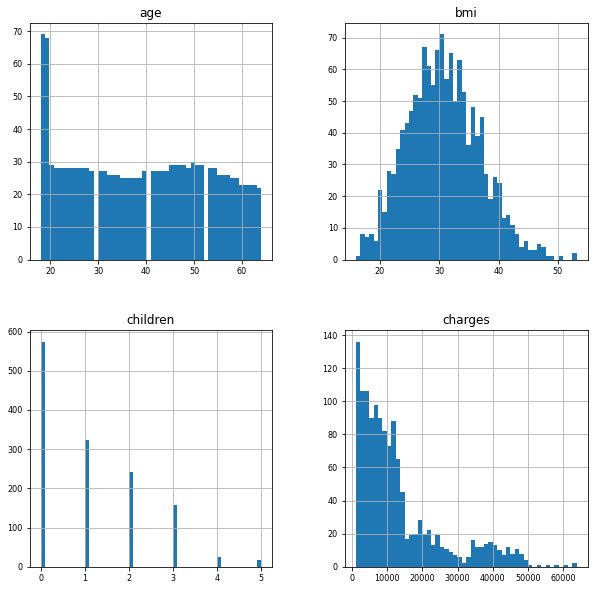

In [7]:
graph_insight(df)

-BMI is balanced when childrens and charges are right skew, age is pretty even but has a significant outliners at age <20

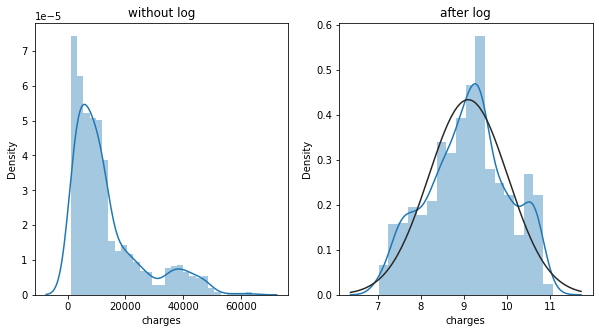

In [8]:
import scipy.stats
plt.figure(figsize=(10, 5))
plt.subplot(1,2,1)
sns.distplot(df.charges)
plt.title('without log')
plt.subplot(1,2,2)
sns.distplot(np.log(df.charges),kde= True,fit=scipy.stats.norm)
plt.title('after log')
plt.show()

data is left skew so we are gonna use log for next steps

In [9]:
np.log(df.charges)

0       9.73
1       7.45
2       8.40
3      10.00
4       8.26
        ... 
1334    7.70
1335    7.40
1336    7.60
1337   10.28
1338   10.45
Name: charges, Length: 1339, dtype: float64

check dupliacte data

In [10]:
drop_duplicate(df)

Before drop shape: (1339, 8)
After drop shape: (1338, 8)
Total Duplicate: 1


In [11]:
df.describe()

,age,bmi,children,charges
count,"1,338.00","1,338.00","1,338.00","1,338.00"
mean,39.23,30.66,1.10,"13,295.00"
std,14.04,6.10,1.21,"12,119.76"
min,18.00,15.96,0.00,"1,121.87"
25%,27.00,26.30,0.00,"4,746.52"
50%,39.00,30.40,1.00,"9,388.75"
75%,51.00,34.69,2.00,"16,746.66"
max,64.00,53.13,5.00,"63,770.43"


<AxesSubplot:>

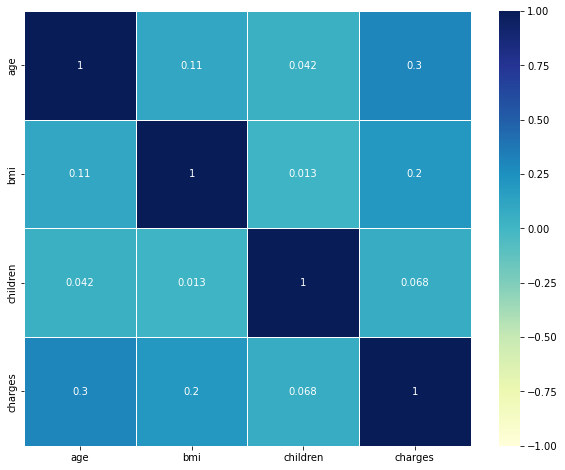

In [12]:
plt.figure(figsize=(10,8))
corr = df.corr()
sns.heatmap(corr, cmap = 'YlGnBu', annot = True, vmin= -1, vmax= 1, linewidths=.5)

-there is almost no correlation betweer charges and age,bmi,children

In [13]:
df.head(10)

,age,sex,bmi,children,smoker,region,houseownership,charges
0,19,female,27.90,0,yes,southwest,apartment,"16,884.92"
1,18,male,33.77,1,no,southeast,apartment,"1,725.55"
2,28,male,33.00,3,no,southeast,rent,"4,449.46"
3,33,male,22.70,0,no,northwest,house,"21,984.47"
4,32,male,28.88,0,no,northwest,rent,"3,866.86"
5,31,female,25.74,0,no,southeast,house,"3,756.62"
6,46,female,33.44,1,no,southeast,house,"8,240.59"
7,37,female,27.74,3,no,northwest,apartment,"7,281.51"
8,37,male,29.83,2,no,northeast,house,"6,406.41"
9,60,female,25.84,0,no,northwest,apartment,"28,923.14"


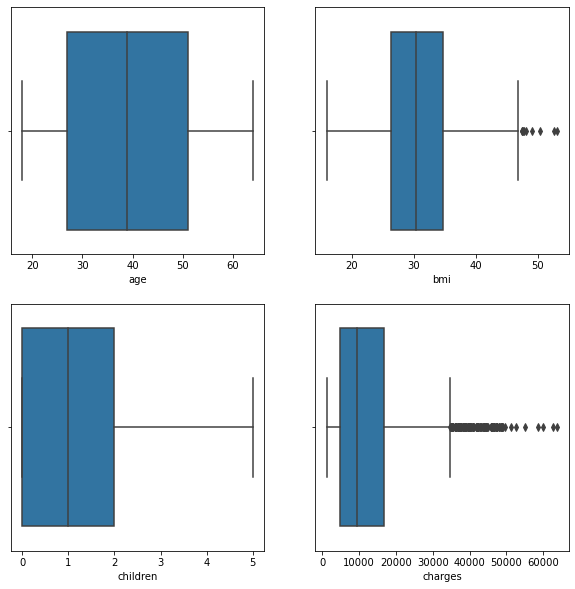

In [14]:
numeric_df = df.select_dtypes(np.number)

plt.figure(figsize = (10,10))
for i in enumerate(numeric_df):
    plt.subplot(2,2,i[0]+1)
    sns.boxplot(x = i[1], data = df)
plt.show()

In [15]:
#age-> bin
bins = [0,20,30,40,50,100]
labels=['<20','20-30','30-40','40-50','>50']
df['AGEGROUP']=pd.cut(df['age'],bins=bins,labels=labels)

In [16]:
#bmi-> bin
bins = [0,20,30,40,50,100]
labels=['<20','20-30','30-40','40-50','>50']
df['bmigroup']=pd.cut(df['bmi'],bins=bins,labels=labels)

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   age             1338 non-null   int64   
 1   sex             1338 non-null   object  
 2   bmi             1338 non-null   float64 
 3   children        1338 non-null   int64   
 4   smoker          1338 non-null   object  
 5   region          1338 non-null   object  
 6   houseownership  1338 non-null   object  
 7   charges         1338 non-null   float64 
 8   AGEGROUP        1338 non-null   category
 9   bmigroup        1338 non-null   category
dtypes: category(2), float64(2), int64(2), object(4)
memory usage: 86.8+ KB


<AxesSubplot:xlabel='age', ylabel='charges'>

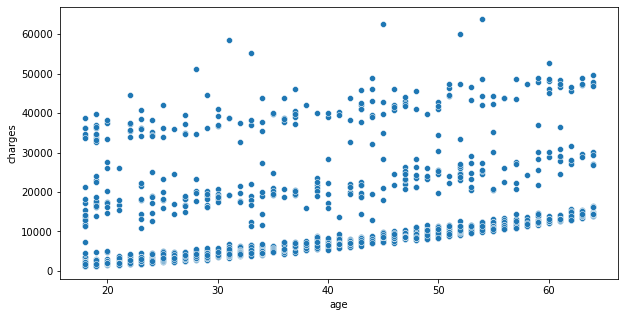

In [18]:
plt.figure(figsize=(10,5))
sns.scatterplot(y='charges',
                x='age',
               data=df)

<AxesSubplot:xlabel='bmi', ylabel='charges'>

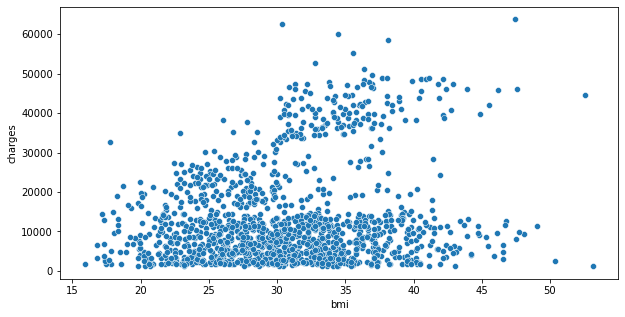

In [19]:
plt.figure(figsize=(10,5))
sns.scatterplot(y='charges',
                x='bmi',
               data=df)

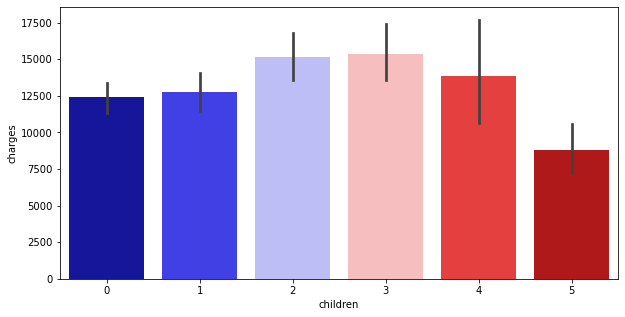

In [20]:
plt.figure(figsize=(10,5))
sns.barplot(y='charges',
                x='children',
               data=df,
           palette='seismic')
plt.show()

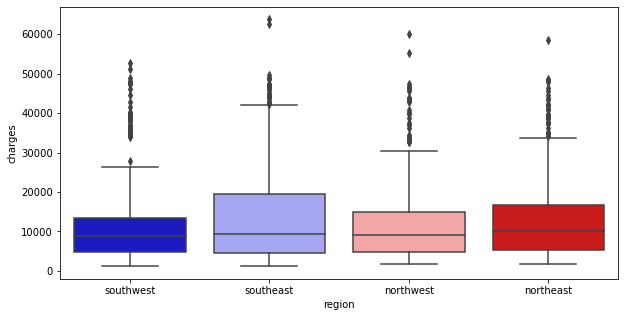

In [21]:
plt.figure(figsize=(10,5))
sns.boxplot( x='region', 
            y='charges',
           data=df,
           palette='seismic')
plt.show()

those live at southest have higher charge than other regions, median are quite same as others, but also have some outliners above 60k.

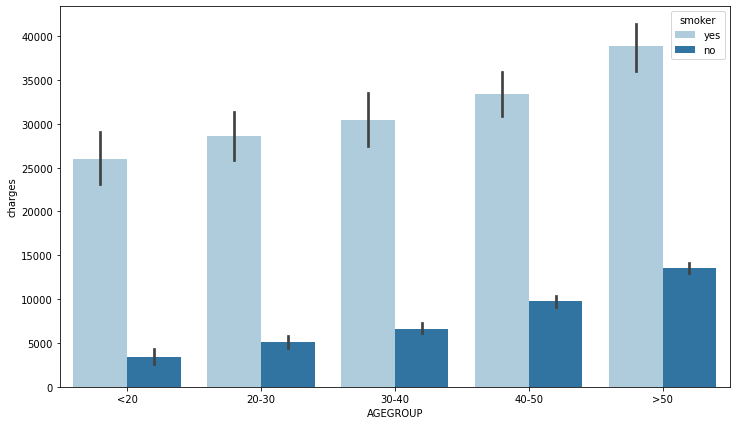

In [22]:
plt.figure(figsize=(12,7))
sns.barplot( hue='smoker',
            x='AGEGROUP',
            y='charges',
           data=df,
           palette='Paired')

plt.show()

those who smoke seem to have higher charges than other and increase by age

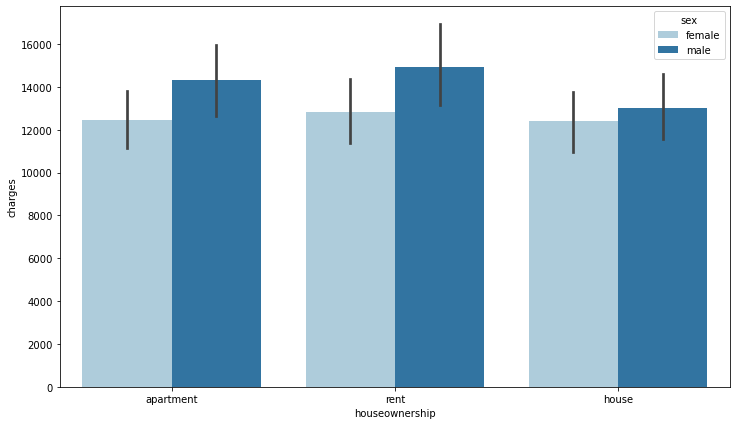

In [23]:
plt.figure(figsize=(12,7))
sns.barplot(hue='sex',
            x='houseownership',
            y='charges',
           data=df,
           palette='Paired')

plt.show()

In [24]:
df_toget_dummy= ['sex','children','smoker','region','houseownership','AGEGROUP','bmigroup']
df3=pd.get_dummies(data = df,
               columns = df_toget_dummy,
            
              dtype='int8')


In [25]:
df2=df3.drop(['age','bmi'],axis=1)
df2

,charges,sex_female,sex_male,children_0,children_1,children_2,children_3,children_4,children_5,smoker_no,smoker_yes,region_northeast,region_northwest,region_southeast,region_southwest,houseownership_apartment,houseownership_house,houseownership_rent,AGEGROUP_<20,AGEGROUP_20-30,AGEGROUP_30-40,AGEGROUP_40-50,AGEGROUP_>50,bmigroup_<20,bmigroup_20-30,bmigroup_30-40,bmigroup_40-50,bmigroup_>50
0,"16,884.92",1,0,1,0,0,0,0,0,0,1,0,0,0,1,1,0,0,1,0,0,0,0,0,1,0,0,0
1,"1,725.55",0,1,0,1,0,0,0,0,1,0,0,0,1,0,1,0,0,1,0,0,0,0,0,0,1,0,0
2,"4,449.46",0,1,0,0,0,1,0,0,1,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,1,0,0
3,"21,984.47",0,1,1,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0
4,"3,866.86",0,1,1,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1333,"2,205.98",1,0,1,0,0,0,0,0,1,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0
1334,"1,629.83",1,0,1,0,0,0,0,0,1,0,0,0,1,0,1,0,0,1,0,0,0,0,0,0,1,0,0
1335,"2,007.94",1,0,1,0,0,0,0,0,1,0,0,0,0,1,1,0,0,0,1,0,0,0,0,1,0,0,0
1336,"29,141.36",1,0,1,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0


In [26]:
df2['charges'] = np.log(df2['charges'])

In [27]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 28 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   charges                   1338 non-null   float64
 1   sex_female                1338 non-null   int8   
 2   sex_male                  1338 non-null   int8   
 3   children_0                1338 non-null   int8   
 4   children_1                1338 non-null   int8   
 5   children_2                1338 non-null   int8   
 6   children_3                1338 non-null   int8   
 7   children_4                1338 non-null   int8   
 8   children_5                1338 non-null   int8   
 9   smoker_no                 1338 non-null   int8   
 10  smoker_yes                1338 non-null   int8   
 11  region_northeast          1338 non-null   int8   
 12  region_northwest          1338 non-null   int8   
 13  region_southeast          1338 non-null   int8   
 14  region_s

In [28]:
X=df2.drop('charges',axis=1)
y=df2['charges']
X_train, X_test, y_train, y_test = train_test_split(X, y , test_size = 0.2,random_state=20)

In [52]:
#test multiple models using cross_val_score

from sklearn.model_selection import cross_val_score
def get_valdiation(model):
    cv=cross_val_score(model,X_train,y_train,cv=10)
    model.fit(X_train,y_train)
    pred=model.predict(X_test)
    print("Regression: {} \n".format(model))
    print("Score: {:.2f} %".format(np.mean(cv)*100))
    print("Standard deviation: {:.2f}".format(np.std(cv)))
    print("R2 score from Predict: {} \n".format(np.round(r2_score(y_test, pred),2)))

    test_residual = y_test - pred
    sns.scatterplot(x=y_test, y=test_residual)
    plt.axhline(y=0,color='r',ls='--')
    plt.title("Regressor : {}".format(model))
    plt.show()
    sns.distplot(test_residual)
    plt.show()

Regression: SVR() 

Score: 80.25 %
Standard deviation: 0.06
R2 score from Predict: 0.86 



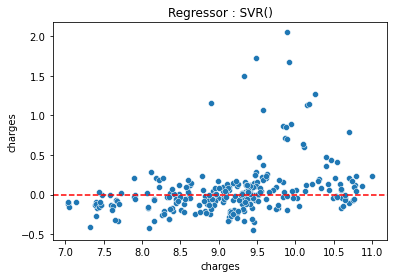

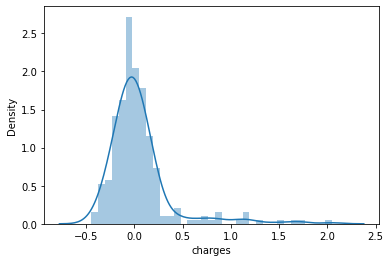

Regression: ElasticNet(alpha=10) 

Score: -0.90 %
Standard deviation: 0.01
R2 score from Predict: -0.0 



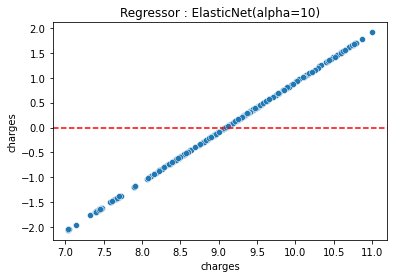

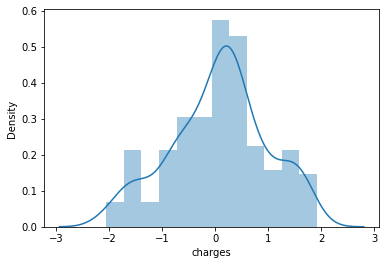

Regression: Lasso(alpha=10) 

Score: -0.90 %
Standard deviation: 0.01
R2 score from Predict: -0.0 



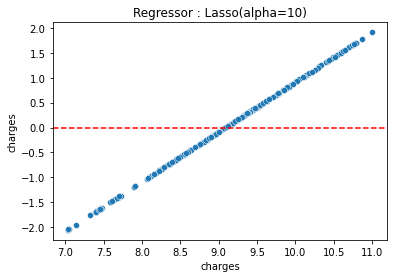

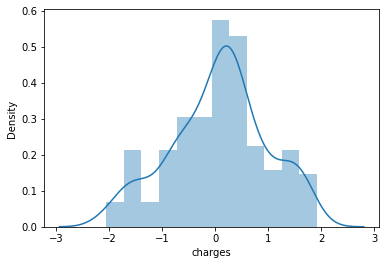

Regression: Ridge() 

Score: 73.58 %
Standard deviation: 0.04
R2 score from Predict: 0.8 



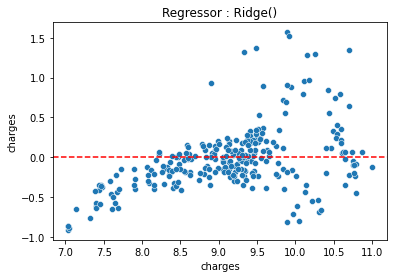

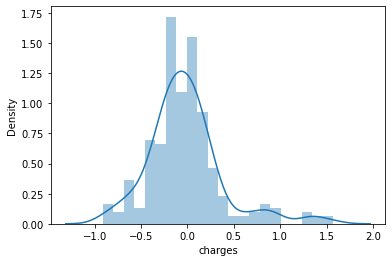

Regression: SGDRegressor() 

Score: 71.47 %
Standard deviation: 0.05
R2 score from Predict: 0.77 



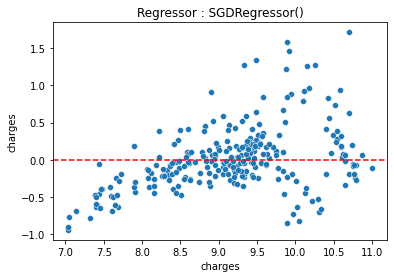

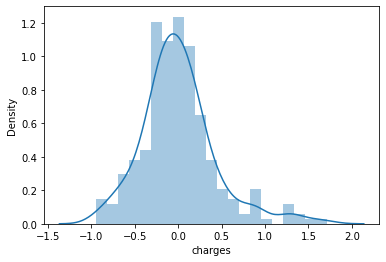

Regression: LinearRegression() 

Score: 73.48 %
Standard deviation: 0.04
R2 score from Predict: 0.79 



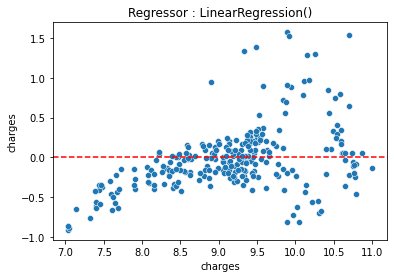

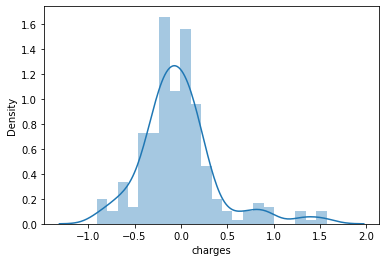

Regression: RandomForestRegressor() 

Score: 75.22 %
Standard deviation: 0.06
R2 score from Predict: 0.82 



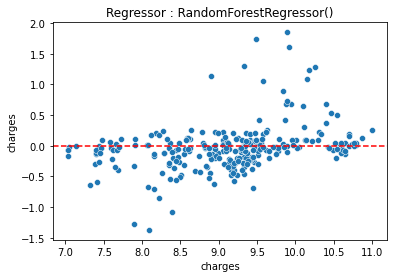

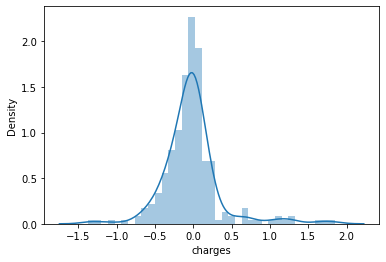

Regression: AdaBoostRegressor() 

Score: 70.42 %
Standard deviation: 0.05
R2 score from Predict: 0.76 



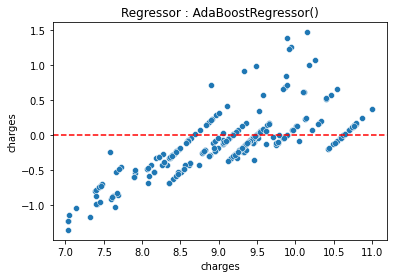

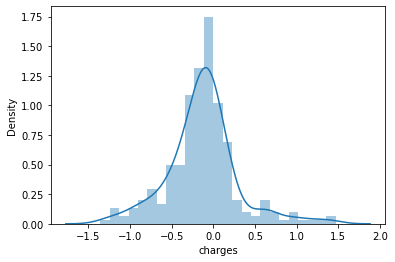

In [56]:
model = [SVR(),ElasticNet(alpha=10),Lasso(alpha=10),Ridge(),SGDRegressor(), LinearRegression(),RandomForestRegressor(), AdaBoostRegressor()]
for i in model:
    get_valdiation(i)

we choose the svr as most effective model

In [54]:
model1=SVR()
model1.fit(X_train,y_train)
y_predict=model1.predict(X_test)

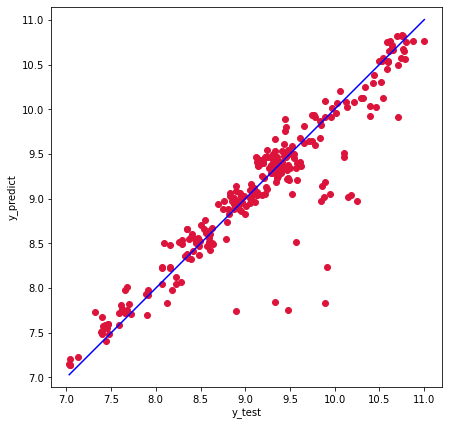

In [38]:
plt.figure(figsize=(7,7))
plt.scatter(y_test,y_predict,c='crimson')
p1=(max(max(y_predict),max(y_test)))
p2=min(min(y_predict),min(y_test))
plt.plot([p1,p2],[p1,p2],'b-')
plt.ylabel('y_predict')
plt.xlabel('y_test')
plt.axis('equal')
plt.show()

we can see from the chart above, the predict value is quite same as the test value, but still have some outliners when the real value (log) from 9-11

In [67]:
def result (row):
    
    data=X_test.iloc[[row]]
    data_predict=model1.predict(data)

    print(' test value:',list(np.exp(y_test.iloc[[row]])),'\n','predict value:',list(np.exp(data_predict)))
    return

In [71]:
#example:
result(46)

 test value: [5400.980499999998] 
 predict value: [5624.685296817719]
